In [1]:
import spotipy
import time
import matplotlib.pyplot as plt
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
import os

In [13]:
# Cargar variables del archivo .env
load_dotenv()

# Leer las variables
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')

In [14]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [15]:
# Ejemplo: buscar un artista
results = sp.search(q='The Weeknd', type='artist')


In [16]:
# Raw data 
results

{'artists': {'href': 'https://api.spotify.com/v1/search?offset=0&limit=10&query=The%20Weeknd&type=artist',
  'limit': 10,
  'next': 'https://api.spotify.com/v1/search?offset=10&limit=10&query=The%20Weeknd&type=artist',
  'offset': 0,
  'previous': None,
  'total': 826,
  'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ'},
    'followers': {'href': None, 'total': 104956110},
    'genres': [],
    'href': 'https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ',
    'id': '1Xyo4u8uXC1ZmMpatF05PJ',
    'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb9e528993a2820267b97f6aae',
      'height': 640,
      'width': 640},
     {'url': 'https://i.scdn.co/image/ab676161000051749e528993a2820267b97f6aae',
      'height': 320,
      'width': 320},
     {'url': 'https://i.scdn.co/image/ab6761610000f1789e528993a2820267b97f6aae',
      'height': 160,
      'width': 160}],
    'name': 'The Weeknd',
    'popularity': 97,
    'type': 'artist',

In [17]:
artist = results['artists']['items'][0]
print(f"Nombre del artista: {artist['name']}")
print(f"Popularidad: {artist['popularity']}")
print(f"Géneros: {artist['genres']}")

Nombre del artista: The Weeknd
Popularidad: 97
Géneros: []


In [18]:
# Ejemplo: obtener las canciones top de un artista
top_tracks = sp.artist_top_tracks(artist['id'])
print("\nCanciones más populares:")
for i, track in enumerate(top_tracks['tracks'][:5]):
    print(f"{i+1}. {track['name']}")


Canciones más populares:
1. Timeless (feat Playboi Carti)
2. One Of The Girls (with JENNIE, Lily Rose Depp)
3. Starboy
4. Blinding Lights
5. Die For You


In [19]:
redirect_uri = "http://127.0.0.1:8888/callback"  # Puede ser cualquier URL, incluso si no existe

# Inicializar Spotify con OAuth
# El scope 'user-read-recently-played' es necesario para acceder al historial
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri=redirect_uri,
    scope="user-read-recently-played",
    cache_path=".spotify_cache"  # Guarda el token para no tener que autenticarte cada vez
))


In [20]:
# Obtener las reproducciones recientes (máximo 50)
recent_tracks = sp.current_user_recently_played(limit=50)

In [21]:
# Crear una lista para almacenar la información
tracks_list = []

# Procesar cada track
for item in recent_tracks['items']:
    track = item['track']
    played_at = item['played_at']
    
    # Convertir la fecha de ISO 8601 a formato más legible
    played_at_formatted = time.strftime(
        '%Y-%m-%d %H:%M:%S', 
        time.strptime(played_at, '%Y-%m-%dT%H:%M:%S.%fZ')
    )
    
    # Obtener artistas (puede haber varios)
    artists = ", ".join([artist['name'] for artist in track['artists']])
    
    # Añadir a la lista
    tracks_list.append({
        'Reproducido el': played_at_formatted,
        'Canción': track['name'],
        'Artista(s)': artists,
        'Álbum': track['album']['name'],
        'Duración (ms)': track['duration_ms'],
        'Popularidad': track['popularity']
    })

# Convertir a DataFrame para mejor visualización
df = pd.DataFrame(tracks_list)

# Mostrar las reproducciones recientes
print(f"Tus {len(tracks_list)} reproducciones más recientes:")
print(df[['Reproducido el', 'Canción', 'Artista(s)', 'Álbum']])

# Opcionalmente, guardar en un CSV
df.to_csv('mis_reproducciones_recientes.csv', index=False)
print("\nDatos guardados en 'mis_reproducciones_recientes.csv'")

Tus 50 reproducciones más recientes:
         Reproducido el                                      Canción  \
0   2025-05-16 17:44:26                                      La Nena   
1   2025-05-16 17:41:30                                Rey Sin Reina   
2   2025-05-16 17:38:59              El Mayor de los Ranas (En Vivo)   
3   2025-05-16 17:36:03                                No Es Por Acá   
4   2025-05-15 20:26:19                        Pongámonos De Acuerdo   
5   2025-05-15 20:23:30                                      Que Sea   
6   2025-05-15 20:20:36                               Amor Del Bueno   
7   2025-05-15 20:17:06                               Amor Del Bueno   
8   2025-05-15 20:02:24                                 Me la Avente   
9   2025-05-15 19:58:08                               Por Las Noches   
10  2025-05-15 19:54:09                                    Di Que Sí   
11  2025-05-15 19:50:59                                          CCC   
12  2025-05-15 19:48:51    

In [22]:
# Definir los rangos de tiempo disponibles
time_ranges = ["short_term", "medium_term", "long_term"]
time_ranges_desc = {
    "short_term": "Últimas 4 semanas",
    "medium_term": "Últimos 6 meses",
    "long_term": "Varios años"
}


In [24]:
# Función para obtener y mostrar los artistas top para un rango de tiempo
def get_top_artists(time_range="medium_term", limit=50):
    """
    Obtiene los artistas más escuchados para un rango de tiempo específico
    
    Args:
        time_range: Período sobre el cual se calculan las afinidades
                   (short_term, medium_term, long_term)
        limit: Número de artistas a obtener
    
    Returns:
        DataFrame con la información de los artistas
    """
    print(f"\n--- Top {limit} Artistas ({time_ranges_desc[time_range]}) ---")
    
    # Llamar a la API para obtener los artistas top
    results = sp.current_user_top_artists(
        limit=limit,
        offset=0,  # Empezar desde el primer resultado
        time_range=time_range
    )
    
    # Extraer la información relevante de cada artista
    artists_data = []
    for i, artist in enumerate(results['items']):
        artist_info = {
            'rank': i+1,
            'name': artist['name'],
            'popularity': artist['popularity'],
            'followers': artist['followers']['total'],
            'genres': ', '.join(artist['genres']) if artist['genres'] else 'No genres',
            'id': artist['id'],
            'image_url': artist['images'][0]['url'] if artist['images'] else 'No image'
        }
        artists_data.append(artist_info)
    
    # Crear un DataFrame con los datos
    df = pd.DataFrame(artists_data)
    
    # Mostrar el DataFrame
    display(df[['rank', 'name', 'popularity', 'followers', 'genres']])
    
    return df

In [39]:
# Obtener y mostrar los artistas top para cada rango de tiempo
top_artists_dfs = {}
for time_range in time_ranges:
    df = get_top_artists(time_range=time_range, limit=50)
    top_artists_dfs[time_range] = df



--- Top 50 Artistas (Últimas 4 semanas) ---


,rank,name,popularity,followers,genres
0,1,Zoé,76,6998724,"rock en español, mexican rock, mexican indie, ..."
1,2,Bad Bunny,100,95500028,"reggaeton, trap latino, urbano latino, latin"
2,3,Calibre 50,77,12525791,"banda, corrido, norteño, música mexicana, sier..."
3,4,Ozuna,88,38547334,"reggaeton, trap latino, latin, urbano latino"
4,5,Maná,79,12868945,"rock en español, latin rock, mexican rock, lat..."
5,6,Shakira,88,37984457,latin pop
6,7,Eden Muñoz,77,2825410,"banda, corrido, norteño, corridos bélicos, cor..."
7,8,Carín León,86,16005577,"banda, norteño, sierreño, corrido, grupera, ra..."
8,9,Alejandro Fernández,78,8345517,"mariachi, ranchera, latin pop, bolero"
9,10,Los Horóscopos De Durango,65,883285,"duranguense, banda, grupera, música mexicana"



--- Top 50 Artistas (Últimos 6 meses) ---


,rank,name,popularity,followers,genres
0,1,Bad Bunny,100,95500028,"reggaeton, trap latino, urbano latino, latin"
1,2,Maná,79,12868945,"rock en español, latin rock, mexican rock, lat..."
2,3,Eden Muñoz,77,2825410,"banda, corrido, norteño, corridos bélicos, cor..."
3,4,Robbie Williams,75,3184146,No genres
4,5,Zoé,76,6998724,"rock en español, mexican rock, mexican indie, ..."
5,6,Yuridia,76,5438593,latin pop
6,7,Calibre 50,77,12525791,"banda, corrido, norteño, música mexicana, sier..."
7,8,Intocable,74,4296489,"tejano, norteño, grupera, banda, cumbia norteñ..."
8,9,Kendrick Lamar,95,41199276,"hip hop, west coast hip hop"
9,10,Coldplay,91,58352678,No genres



--- Top 50 Artistas (Varios años) ---


,rank,name,popularity,followers,genres
0,1,Bad Bunny,100,95500028,"reggaeton, trap latino, urbano latino, latin"
1,2,Matisse,66,1147174,No genres
2,3,Maná,79,12868945,"rock en español, latin rock, mexican rock, lat..."
3,4,The Beatles,86,29920572,"classic rock, psychedelic rock"
4,5,Eden Muñoz,77,2825410,"banda, corrido, norteño, corridos bélicos, cor..."
5,6,Carín León,86,16005577,"banda, norteño, sierreño, corrido, grupera, ra..."
6,7,The Killers,79,7814939,alternative rock
7,8,Alejandro Fernández,78,8345517,"mariachi, ranchera, latin pop, bolero"
8,9,Carla Morrison,73,4781988,latin indie
9,10,Julión Álvarez y su Norteño Banda,84,9681003,"banda, norteño, grupera, corrido"


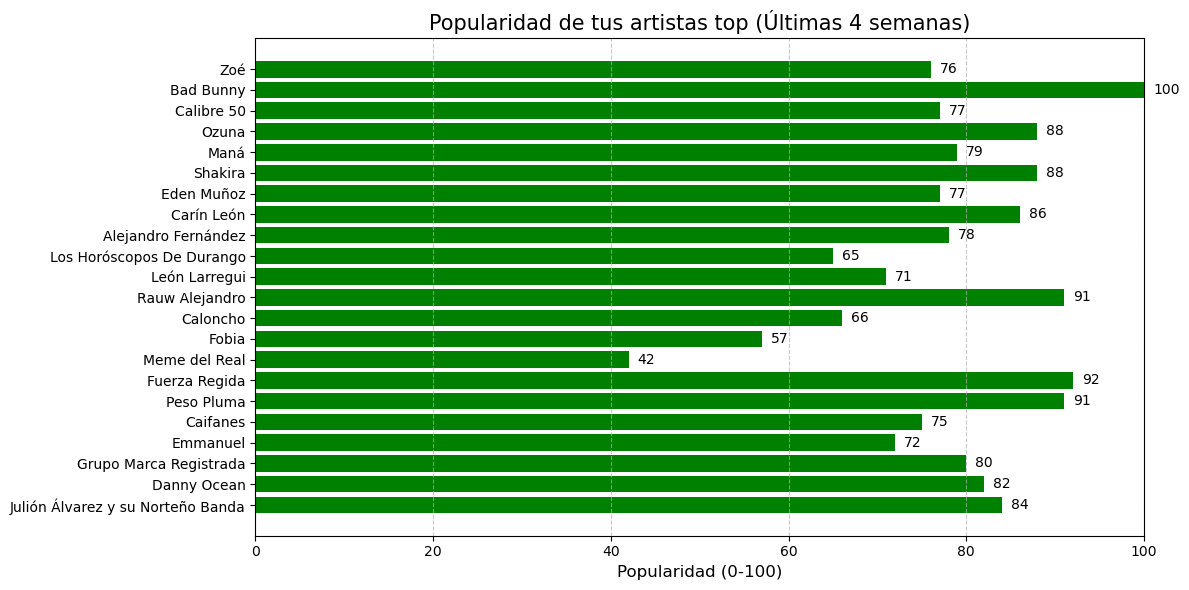

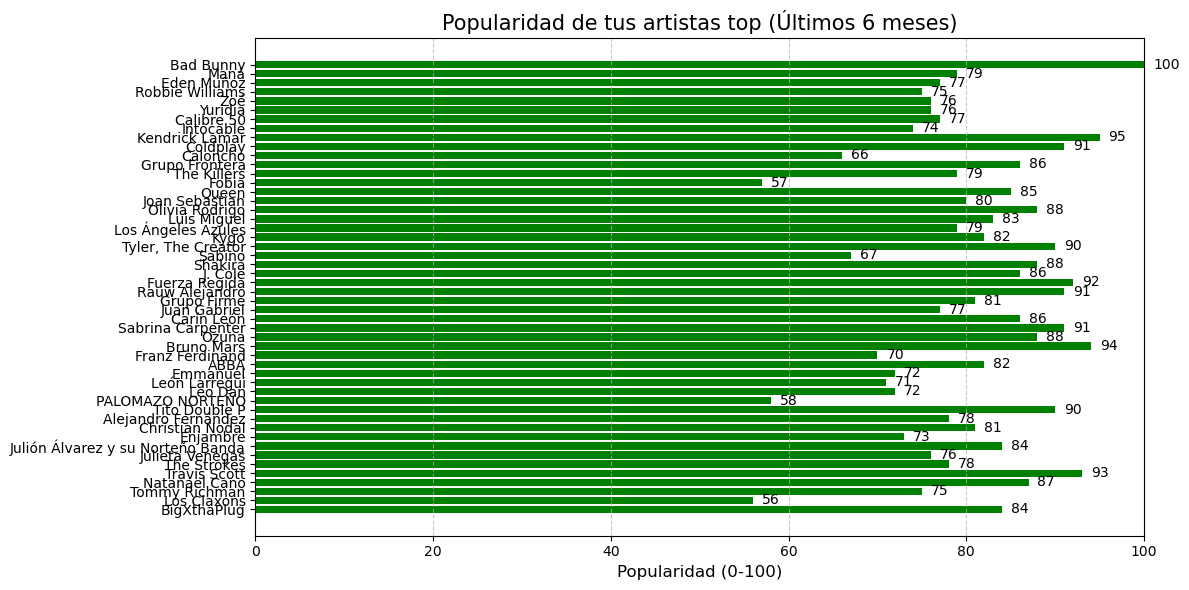

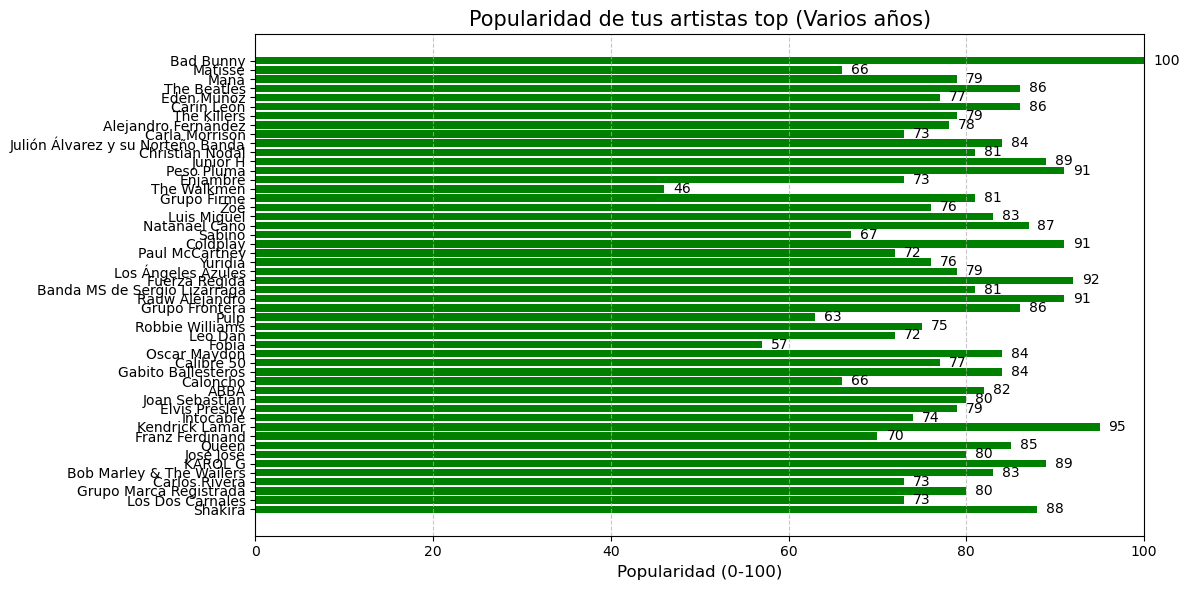


--- Comparación de Artistas Top entre Diferentes Períodos ---


,name,Últimas 4 semanas,Últimos 6 meses,Varios años
61,Bad Bunny,2.0,1.0,1.0
62,Maná,5.0,2.0,3.0
69,Eden Muñoz,7.0,3.0,5.0
47,Robbie Williams,NaN,4.0,30.0
54,Zoé,1.0,5.0,17.0
67,Yuridia,NaN,6.0,23.0
4,Calibre 50,3.0,7.0,34.0
42,Intocable,NaN,8.0,40.0
27,Kendrick Lamar,NaN,9.0,41.0
68,Coldplay,NaN,10.0,21.0



Análisis completado. Has explorado tus artistas más escuchados en diferentes períodos de tiempo.


In [47]:
def plot_top_artists_popularity(df, time_range):
    plt.figure(figsize=(12, 6))
    
    # Invertir el orden para que el top 1 esté arriba
    artists = df['name'].values[::-1]
    popularity = df['popularity'].values[::-1]
    
    # Crear gráfico de barras horizontales
    bars = plt.barh(artists, popularity, color='green')
    
    # Personalizar el gráfico
    plt.title(f'Popularidad de tus artistas top ({time_ranges_desc[time_range]})', fontsize=15)
    plt.xlabel('Popularidad (0-100)', fontsize=12)
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Añadir valores a las barras
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                 va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Mostrar gráficos de popularidad para cada rango de tiempo
for time_range in time_ranges:
    plot_top_artists_popularity(top_artists_dfs[time_range], time_range)

# Comparar los artistas top entre diferentes períodos de tiempo
def compare_time_ranges():
    print("\n--- Comparación de Artistas Top entre Diferentes Períodos ---")
    
    # Crear un conjunto con todos los artistas únicos
    all_artists = set()
    for df in top_artists_dfs.values():
        all_artists.update(df['name'].values)
    
    # Crear un DataFrame para la comparación
    comparison_data = []
    for artist in all_artists:
        artist_ranks = {}
        for time_range in time_ranges:
            df = top_artists_dfs[time_range]
            artist_row = df[df['name'] == artist]
            rank = artist_row['rank'].values[0] if not artist_row.empty else None
            artist_ranks[time_range] = rank
        
        comparison_data.append({
            'name': artist,
            'short_term_rank': artist_ranks['short_term'],
            'medium_term_rank': artist_ranks['medium_term'],
            'long_term_rank': artist_ranks['long_term']
        })
    
    # Crear y mostrar DataFrame de comparación
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values(by='medium_term_rank')
    
    # Renombrar columnas para mayor claridad
    comparison_df = comparison_df.rename(columns={
        'short_term_rank': 'Últimas 4 semanas',
        'medium_term_rank': 'Últimos 6 meses',
        'long_term_rank': 'Varios años'
    })
    
    # Mostrar solo artistas que aparecen en al menos dos rangos de tiempo
    valid_comparisons = comparison_df.dropna(thresh=3)  # Al menos 2 valores no NaN
    display(valid_comparisons)
    
    return comparison_df

# Ejecutar la comparación entre rangos de tiempo
comparison_df = compare_time_ranges()

print("\nAnálisis completado. Has explorado tus artistas más escuchados en diferentes períodos de tiempo.")